In [1]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.9 MB/s eta 0:00:00


In [2]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [3]:
# download model and data
!wget -O img_demo.png https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-05-09 23:42:26--  https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87865 (86K) [image/png]
Saving to: ‘img_demo.png’

img_demo.png        100%[===================>]  85.81K  --.-KB/s    in 0.02s   

2025-05-09 23:42:26 (4.58 MB/s) - ‘img_demo.png’ saved [87865/87865]

--2025-05-09 23:42:26--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[==================

In [4]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [7]:
img_np.shape

(708, 990)

In [16]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# box_np = np.array([[95,255, 190, 350]])
# # transfer box_np t0 1024x1024 scale
# box_1024 = box_np / np.array([W, H, W, H]) * 1024

box_np = np.array([[0, 0, W, H]])  # весь исходный размер
box_1024 = box_np / np.array([W, H, W, H]) * 1024

with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

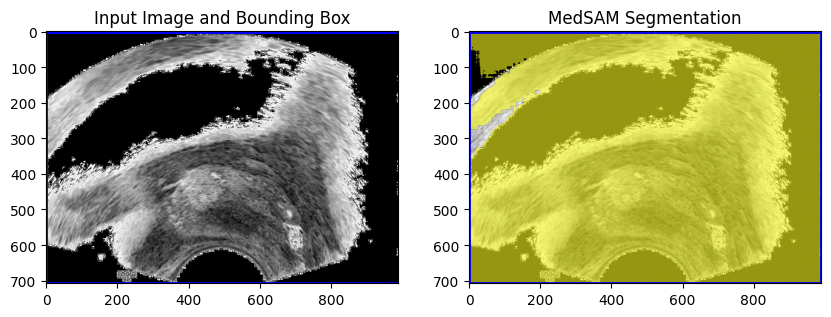

In [17]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


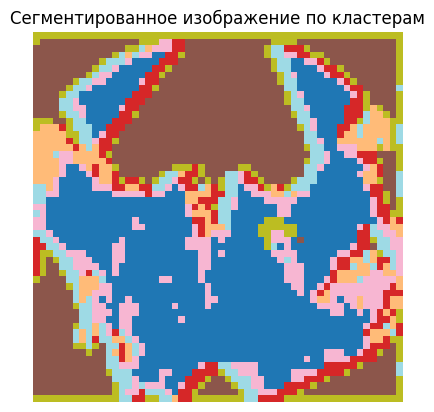

In [36]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet50
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загрузка изображения
image = cv2.imread("23.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Извлечение признаков
model = resnet50(pretrained=True)
model.eval()
with torch.no_grad():
    features = model.conv1(input_tensor)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)

features = features.squeeze(0).permute(1, 2, 0)  # (H, W, C)
h_feat, w_feat = features.shape[:2]
features_np = features.reshape(-1, features.shape[2]).numpy()

# Кластеризация
k = 7
kmeans = KMeans(n_clusters=k, random_state=0).fit(features_np)
seg_map = kmeans.labels_.reshape(h_feat, w_feat)

# Визуализация
plt.imshow(seg_map, cmap="tab20")
plt.title("Сегментированное изображение по кластерам")
plt.axis("off")
plt.show()

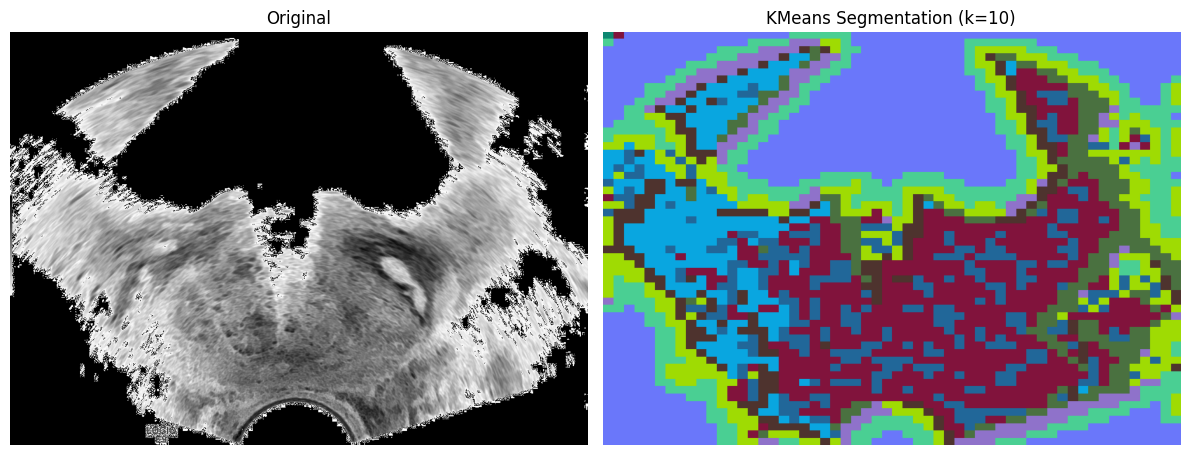

In [32]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image

# === 1. Загружаем изображение ===
img_path = '23.png'  # замените на путь к вашему изображению
image = Image.open(img_path).convert("RGB")
orig_w, orig_h = image.size

transform = T.Compose([
    T.Resize((448, 448)),  # уменьшаем изображение для ускорения
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
img_tensor = transform(image).unsqueeze(0).cuda()

# === 2. Загружаем ResNet и обрезаем до более раннего слоя (например, layer2) ===
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).cuda().eval()
backbone = torch.nn.Sequential(*list(resnet.children())[:6])  # до layer2

with torch.no_grad():
    features = backbone(img_tensor)  # shape: (B, C, H, W)
features = features.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)

# === 3. Преобразуем в 2D и уменьшаем размерность с помощью PCA ===
h, w, c = features.shape
features_2d = features.reshape(-1, c)

pca = PCA(n_components=20)
features_pca = pca.fit_transform(features_2d)

# === 4. Кластеризация ===
k = 10  # число сегментов
kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
seg_map = kmeans.labels_.reshape(h, w)

# === 5. Визуализация ===
seg_img = np.zeros((h, w, 3), dtype=np.uint8)
colors = np.random.randint(0, 255, (k, 3))
for i in range(h):
    for j in range(w):
        seg_img[i, j, :] = colors[seg_map[i, j]]

# Увеличим обратно до оригинального размера
seg_img = cv2.resize(seg_img, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'KMeans Segmentation (k={k})')
plt.imshow(seg_img)
plt.axis('off')
plt.tight_layout()
plt.show()


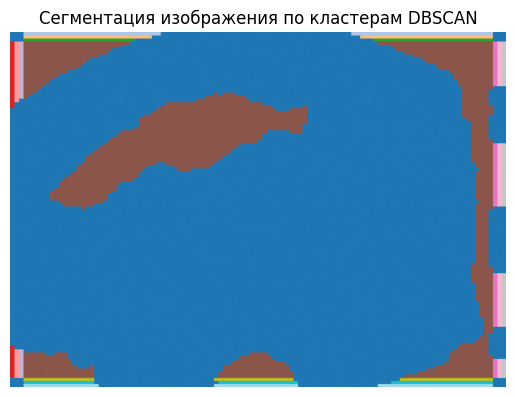

In [50]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet50
from sklearn.cluster import DBSCAN
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загрузка изображения
image = cv2.imread("img.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Преобразование изображения
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((448, 448)),  # Увеличиваем размер, чтобы получить больше данных для сегментации
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)

# Извлечение признаков
model = resnet50(weights="IMAGENET1K_V1")
model.eval()
with torch.no_grad():
    features = model.conv1(input_tensor)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)
    features = model.layer1(features)  # Используем слой layer1 для более детализированных признаков

# Получаем размерность признаков
features = features.squeeze(0).permute(1, 2, 0)  # Изменяем размерность на (H, W, C)

# Получаем размерность признаков для каждого пикселя
h, w, c = features.shape
features_flattened = features.reshape(-1, c).numpy()

# Применение DBSCAN для кластеризации
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Понижаем eps и уменьшаем min_samples для поиска более мелких объектов
labels = dbscan.fit_predict(features_flattened)

# Восстановление карты сегментации в исходный размер
seg_map = labels.reshape(h, w)

# Масштабируем карту сегментации обратно в исходный размер изображения
seg_map_resized = cv2.resize(seg_map.astype(np.float32), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Визуализация
plt.imshow(seg_map_resized, cmap="tab20")
plt.title("Сегментация изображения по кластерам DBSCAN")
plt.axis("off")
plt.show()


In [38]:
image.shape


(708, 990, 3)

In [52]:
!pip install transformers

In [71]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision.models import vit_b_16

# Загружаем модель Vision Transformer (ViT) с предобученными весами
model = vit_b_16(weights="IMAGENET1K_V1")

# Переводим модель в режим оценки
model.eval()

# Загружаем изображение
image = cv2.imread("img.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Преобразуем изображение
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),  # Изменим размер на 224x224 для ViT
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)

# Прогоняем изображение через модель
with torch.no_grad():
    outputs = model(input_tensor)  # Получаем предсказания от модели

# Извлекаем признаки из скрытых слоев (выходы перед классификатором)
features = model.embeddings(input_tensor)  # Получаем патчи

# Сжатие выходных данных в 2D массив для кластеризации
patch_size = 16
h, w = image.shape[:2]
n_patches_h = h // patch_size
n_patches_w = w // patch_size

# Преобразуем выходные признаки в 2D
features_reshaped = features.flatten(2).transpose(1, 2)  # [batch_size, num_patches, emb_dim]

# Применяем KMeans для кластеризации
k = 5  # количество кластеров
kmeans = KMeans(n_clusters=k, random_state=0).fit(features_reshaped[0].cpu().numpy())  # Кластеризация признаков
labels = kmeans.labels_

# Восстановим сегментацию в исходный размер
seg_map = labels.reshape(n_patches_h, n_patches_w)  # Восстанавливаем сегментацию в размер сетки 16x16

# Масштабируем сегментацию до исходных размеров изображения
seg_map_resized = cv2.resize(seg_map.astype(np.float32), (w, h), interpolation=cv2.INTER_NEAREST)

# Визуализируем сегментированное изображение
plt.imshow(seg_map_resized, cmap="tab20")
plt.title("Сегментация с использованием ViT и KMeans")
plt.axis("off")
plt.show()


AttributeError: 'VisionTransformer' object has no attribute 'embeddings'

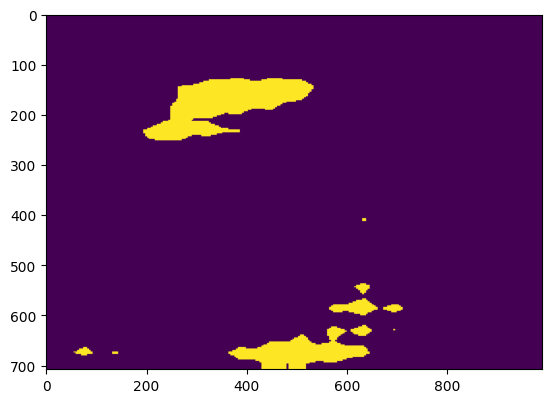

In [67]:
import cv2
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt

# Загрузим предобученную модель DeepLabV3
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Загрузим изображение
image_path = 'img.png'  # Укажите путь к вашему изображению
image = cv2.imread(image_path)

# Изменим размер изображения
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (256, 256))

# Применим необходимые преобразования
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)

# Если есть доступ к GPU, используем его
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_batch = input_batch.to(device)

# Получим результаты сегментации
with torch.no_grad():
    output = model(input_batch)['out'][0]
    output_predictions = torch.argmax(output, dim=0)

# Восстановим сегментацию в исходный размер
h, w = image.shape[:2]
# Проверим размер выходных данных
output_predictions = output_predictions.cpu().numpy()
seg_map = cv2.resize(output_predictions.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)

# Визуализируем сегментированное изображение
plt.imshow(seg_map)
plt.show()


In [55]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00


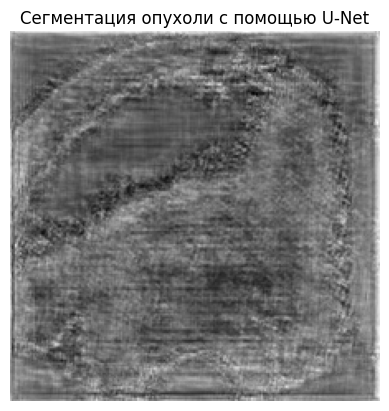

In [59]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загружаем модель U-Net
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_encoder

# Загружаем предобученную модель
model = Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=1, activation="sigmoid")
model.eval()

# Загружаем изображение
image = cv2.imread("img.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Подготавливаем изображение
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Прогоняем через модель
with torch.no_grad():
    output = model(input_tensor)

# Сегментация
seg_map = output.squeeze().cpu().numpy()

# Визуализация
plt.imshow(seg_map, cmap="gray")
plt.title("Сегментация опухоли с помощью U-Net")
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 182MB/s]


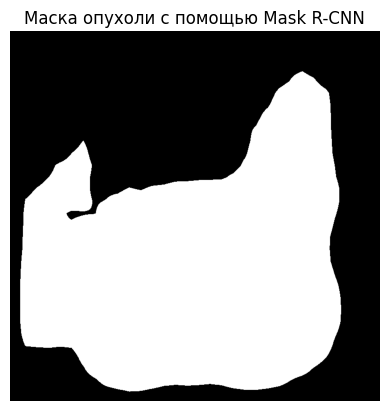

In [58]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Загружаем модель Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Загружаем изображение
image = cv2.imread("img.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Подготавливаем изображение
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((800, 800)),
    T.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

# Прогоняем через модель
with torch.no_grad():
    prediction = model(input_tensor)

# Извлекаем маски
masks = prediction[0]['masks']
labels = prediction[0]['labels']

# Визуализация первой маски
mask = masks[0, 0].cpu().numpy() > 0.5  # Применяем порог

plt.imshow(mask, cmap="gray")
plt.title("Маска опухоли с помощью Mask R-CNN")
plt.axis("off")
plt.show()
